### Problem Set up
In this question we compare the effectiveness of different linear classifiers and regression
models on the Boston housing and Iris dataset.

### Background
The Boston housing dataset involves predicting average housing prices in an area given
features of the area (e.g. average number of rooms per house, average age of owners,
etc...). The Iris dataset involves predicting between 3 types of irises given the features
of the plant (e.g. petal length, petal width, etc...), however here we only predict on the
first two iris types to keep the dataset binary.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_boston, load_iris
from sklearn.preprocessing import PolynomialFeatures
import math

### Loading datasets
We begin by loading both the Boston and Iris datasets.

In [8]:
# Define a random state for reproducibility.
random_state = np.random.RandomState(0)

# Load and shuffle the Boston dataset. Only subsample some features.
boston_X, boston_y = load_boston(return_X_y=True)
permutation = random_state.permutation(boston_X.shape[0])
boston_X = boston_X[permutation][:, [5, 6]]
boston_y = boston_y[permutation]

# Split the dataset into train and test sets.
boston_X_train = boston_X[:-100]
boston_y_train = boston_y[:-100]
boston_X_test = boston_X[-100:]
boston_y_test = boston_y[-100:]

# Create a new featurization for the boston dataset by turning the current
# features into a tenth degree polynomial.
boston_poly_X_train = PolynomialFeatures(8).fit_transform(boston_X_train)
boston_poly_X_test = PolynomialFeatures(8).fit_transform(boston_X_test)

# Now load and shuffle the Iris dataset.
# Discarding all output labels that correspond to a 2.
iris_X, iris_y = load_iris(return_X_y=True)
iris_X = iris_X[:100]
iris_y = iris_y[:100]
permutation = random_state.permutation(iris_X.shape[0])
iris_X = iris_X[permutation]
iris_y = iris_y[permutation]

# Split the dataset into train and test sets.
iris_X_train = iris_X[:-20]
iris_y_train = iris_y[:-20]
iris_X_test = iris_X[-20:]
iris_y_test = iris_y[-20:]

###  Regression and Prediction functions 
We now define the regression and prediction functions. 

The squared loss (with regularization) with respect to linear regression is defined as $\|X\beta - y\|_2^2 + \lambda \|\beta\|_2^2$ where $\beta$ is the linear model, $X$ is the feature matrix, $\lambda$ is a regularization term, and $y$ are the true output values. The derivative of $\|X\beta - y\|_2^2$ with respect to $\beta$ is $2X^{\top}(X\beta - y)$ and the derivative of $\lambda \|\beta\|_2^2$ is $2\lambda \beta$.

The cross entropy loss with respect to logistic regression is defined as $-\frac{1}{n} \sum_{i=1}^n \left[y_i \log \sigma(x_i^{\top}\beta) + (1 - y_i)\log\sigma(-x_i^{\top}\beta)\right]$.

In [2]:
def regression_predict(X, beta):
    """Given a linear model (aka a vector) and a feature matrix
    predict the output vector.
    
    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    beta : numpy array of shape d
        The linear model.
    
    Returns
    -------
    y : numpy array of shape n
        The predicted output vector.
    """
    y = np.dot(X,beta).T
    return y

def regression_least_squares(X, true_y, lambda_value):
    """Compute the optimal linear model that minimizes the regularized squared loss.

    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    true_y : numpy array of shape n
        The true output vector.
    lambda_value : float
        A non-negative regularization term.
    
    Returns
    -------
    beta : numpy array of shape d
        The optimal linear model.
    """
    d = X.shape[1]
    inverse_part = np.linalg.inv(np.dot(X.T, X) + lambda_value * np.identity(d, dtype = float))
    beta = np.dot(np.dot(inverse_part, X.T), true_y) 
    return beta

We then have:

<div align = "center"> $H(y, p) = - \frac{1}{n} \sum_{i=1}^n \big{(} y_i\log(p_i) + (1-y_i)\log(1-p_i) \big{)}$ </div>

Finding $p$ that minimizes the cross-entropy loss is the same as finding $p$ that maximizes likelihood:

<div align = "center">$H(y, p) ~ = ~ - \frac{1}{n} \sum_{i=1}^n \big{(} y_i\log(p_i) + (1-y_i)\log(1-p_i) \big{)} ~ = ~ -\frac{1}{n} \mathscr{l}(p \mid y)$
    </div>

In [3]:
def sigmoid(x):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-x))

def logistic_predict(X, beta):
    """Given a linear model (aka a vector) and a feature matrix
    predict the probability of the output label being 1 using logistic
    regression.
    
    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    beta : numpy array of shape d
        The linear model.
    
    Returns
    -------
    y : numpy array of shape n
        The predicted output vector.
    """
    X_beta = np.dot(X, beta)
    y = sigmoid(X_beta)
    return y

def logistic_cross_entropy_loss(X, beta, true_y):
    """Output the cross entropy loss of a given logistic model.
    
    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    beta : numpy array of shape d
        The linear model.
    true_y : numpy array of shape n
        The true output vectors. Consists of 0s and 1s.
        
    Returns
    -------
    loss : float
        The value of the loss.
    """
    n = X.shape[0]
    y_pred = logistic_predict(X, beta)
    total_loss = 0
    
    for i in range(n):
        if true_y[i] == 1:
            total_loss -= math.log(y_pred[i]) 
        else:
            total_loss -= math.log(1-y_pred[i])
    
    ce_loss = total_loss/n 
    
    return ce_loss

def logistic_cross_entropy_loss_gradient(X, beta, true_y):
    """Output the gradient of the squared loss evaluated with respect to beta.
    
    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    beta : numpy array of shape d
        The linear model.
    true_y : numpy array of shape n
        The true output vectors.
        
    Returns
    -------
    loss_gradient : numpy array of shape d
        The gradient of the loss evaluated with respect to beta.
    """
    return -np.sum((true_y - sigmoid(X @ beta)) * X.T, axis=1) / X.shape[0]

In [5]:
def gradient_descent(X, init_beta, true_y, loss, loss_gradient,
                     learning_rate, iterations):
    """Performs gradient descent on a given loss function and
    returns the optimized beta.
    
    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    init_beta : numpy array of shape d
        The initial value for the linear model.
    true_y : numpy array of shape n
        The true output vectors.
    loss : function
        The loss function we are optimizing.
    loss_gradient : function
        The gradient function that corresponds to the loss function.
    learning_rate : float
        The learning rate for gradient descent.
    iterations : int
        The number of iterations to optimize the loss for.

    Returns
    -------
    beta : numpy array of shape d
        The optimized beta.
    """
    beta = init_beta

    for i in range(iterations):
        beta = beta - learning_rate* loss_gradient(X,beta, true_y)
    return beta

### Error Metrics RMSE
For the Boston housing dataset we will use the root mean squared error
(RMSE) as our error metric: <br/>
<div align = "center">RMSE$(\hat y) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\hat y_i - y_i)^2} = \frac{1}{\sqrt{n}}\| \hat y - y \|_2$ </div> 
where n is the number of datapoints, $\hat y$ is our predicted price vector and y is the true price vector.<br/>
<br/>We'll train a linear regression model by computing:
$$\hat\beta = \underset{\beta}{\arg\min} \|X_{train}\beta - y_{train} \|_2^2+ \lambda\|\beta\|_2^2$$
 </div>


- Now, plot the RMSE by using boston_X_train as Xtrain and boston_X_test as Xtest using regularization values $\lambda \in \{0, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10\}$ with raw numerical features without any modification.

In [13]:
def RMSE(y_pred, true_y):
    """Given a y_prediction and true_y, calculate the RMSE loss.
    
    Parameters
    ----------
    y_pred : numpy array
        prediction
    true_y : numpy array 
        True y
    
    Returns
    -------
    rmse: float
        RMSE of the given set
    """
    n = len(true_y)
    total = np.sum((y_pred - true_y)**2)
    rmse = math.sqrt(total/n)
    return rmse



lambdas = [0, 10**(-4), 10**(-3), 10**(-2), 10**(-1), 1, 10]

In [28]:
def getRMSE_lambda(lambdas, train_X, train_y, test_X, test_y):
    """Given a list of lambdas, and X and true y, return the corresponding RMSE
    
    Parameters
    ----------
    lambdas : a list of lambdas as regulization factor
    train_X : feature matrix of training set
    train_y : true y of train set
    test_X  : feature matrix of test set
    test_y  : true y of the test set
    
    Returns
    -------
    rmse_train: list of float
        RMSE vs the lambdas on training set, for reference purposes
    rmse_test: list of float
        RMSE vs the lambdas on test set
    """
    rmse_train = []
    rmse_test = []
    for l in lambdas:
        beta = regression_least_squares(train_X, train_y, l)
        y_pred = regression_predict(test_X, beta)
        rmse_test.append(RMSE(y_pred, test_y))
        y_fit = regression_predict(train_X, beta)
        rmse_train.append(RMSE(y_fit, train_y))
        
    return rmse_test, rmse_train

In [30]:
rmse_nonPoly_test, rmse_nonPoly_train = getRMSE_lambda(lambdas,boston_X_train,boston_y_train,boston_X_test,boston_y_test)

- Plot the RMSE by using boston_poly_X_train as Xtrain and boston_poly_X_test as Xtest use regularization values $\lambda \in \{0, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10\}$. This corresponds
to using features $$\phi(x) = [1, x_1^2,x_1x_2,x_2^2,.....,x_1x_2^4, x_2^5]^T$$
where x corresponds to the original features.

In [36]:
rmse_Poly_test, rmse_Poly_train = getRMSE_lambda(lambdas,boston_poly_X_train, boston_y_train,boston_poly_X_test,boston_y_test)



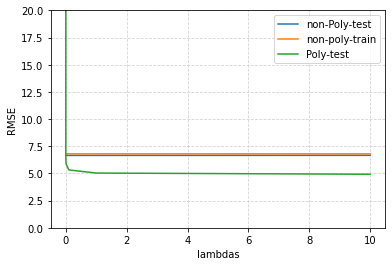

In [44]:
plt.plot(lambdas, rmse_nonPoly_test, label = "non-Poly-test")
plt.plot(lambdas, rmse_nonPoly_train, label = "non-poly-train")
plt.plot(lambdas, rmse_Poly_test, label = "Poly-test")
#plt.plot(lambdas, rmse_Poly_train, label = "poly-train")
plt.xlabel("lambdas")
plt.ylabel("RMSE")
plt.legend()
plt.grid(color='lightgray',linestyle='--')

plt.ylim(0,20)
plt.show()

### Short Recap
The regulization doesn't matter too much on the non-poly case, but effectively drops RMSE on the poly case.

### Error Metric MAE 
For the Iris dataset we will use the mean average error (MAE) as our metric:
<div align = "center"> MAE$(\hat y) = \frac{1}{n}\sum_{i=1}^{n}\mathbb{1}(\hat y_i \neq y_i)$
</div> 
where $\hat y$ is our vector of 0 − 1 predictions and y is the true vector of labels. <br/><br/>
Note that the logistic model outputs a real number $p\in [0, 1]$, which you need to convert to a 0 − 1 decision. To do so use the following decision function:
<div align = "center">  $\delta(p) = \mathbb{1}(p\geq 0.5)$
    </div>

In [63]:
def delta(y_pred, true_y, threshold = 0.5):
    """Given y_pred, true_y, return the error rate decided by logistic regression and delta
    
    Parameters
    ----------
    y_pred : numpy array
        prediction
    true_y : numpy array 
        True y
    threshold: float
        The decision threshold, default at 0.5
    
    Returns
    -------
    error_rate: float
    """
    n = len(y_pred)
    correct = 0
    wrong = 0
    
    for i in range(n):
        if y_pred[i] >= 0.5:
            if true_y[i] == 1:
                correct += 1
            else:
                wrong += 1
        else:
            if true_y[i] == 0:
                correct += 1
            else:
                wrong += 1
                
    error_rate = wrong/(correct + wrong)
    return error_rate

In [72]:
learning_rates = np.arange(start=0.1, stop=1, step=0.1)
init_beta = [0,0,0,0]
error_rate_list = []

In [77]:
for l in learning_rates:
    beta = gradient_descent(iris_X_train, init_beta, iris_y_train, logistic_cross_entropy_loss, 
                         logistic_cross_entropy_loss_gradient, l, 100)
    y_pred = logistic_predict(iris_X_test, beta)
    error_rate_list.append(delta(y_pred, iris_y_test))

With learning rate varied from 0.1-1, and iteration = 100, we can reach an MAE = 0